In [148]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [149]:
dog_breeds = pd.read_csv("data/dog_breeds.csv")
dog_breeds = list(dog_breeds)

In [150]:
IMG_SIZE = 224

def process_image(image_path,img_size=IMG_SIZE):
    """
    Take an image file path and turn image into a Tensor.
    """
    image = tf.io.read_file(image_path) # Read image file
    image = tf.image.decode_jpeg(image,channels=3) # Turn the image into 3 channels RGB
    image = tf.image.convert_image_dtype(image,tf.float32) # Turn the value 0-255 to 0-1
    image = tf.image.resize(image,size=[img_size,img_size]) # Resize the image to 224x224
    return image

def get_image_label(image_path,label):
    """
    Take an image file path name and the associated label,
    process the image and return a tuple of (image,label)
    """
    image = process_image(image_path)
    return image,label

In [151]:
BATCH_SIZE = 32

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X) and lebel (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating testing data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file path (no label)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # If the data is valid dataset, we don't have to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

In [152]:
def get_pred_label(prediction_probabilities):
    """
    Turn an array of prediction probabilities into label.
    """
    return dog_breeds[np.argmax(prediction_probabilities)]

In [153]:
def unbatchify(data):
    """
    Take a batches data of (image,label) Tensors and return seperate arrays of images and labels
    """
    images = []
    labels = []
    for image,label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images,labels

In [154]:
def load_model(model_path):
    """
    Load a saved model from given path
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
    return model

In [155]:
# Save the model
model = load_model("model/20210216-125538-full-image-Adam.h5")

Loading saved model from: model/20210216-125538-full-image-Adam.h5


In [156]:
# Load test image filename
custom_path= "test/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if fname !=".DS_Store"]
custom_data = create_data_batches(custom_image_paths,test_data=True)
custom_preds = model.predict(custom_data)
custom_preds_label = [get_pred_label(cp) for cp in custom_preds]
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

Creating testing data batches...


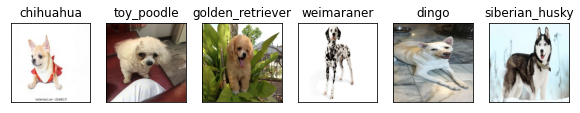

In [157]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
    plt.subplot(1, len(custom_preds_label), i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_preds_label[i])
    plt.imshow(image)